## Eigenvalue gaps of Random Gaussian mixtures

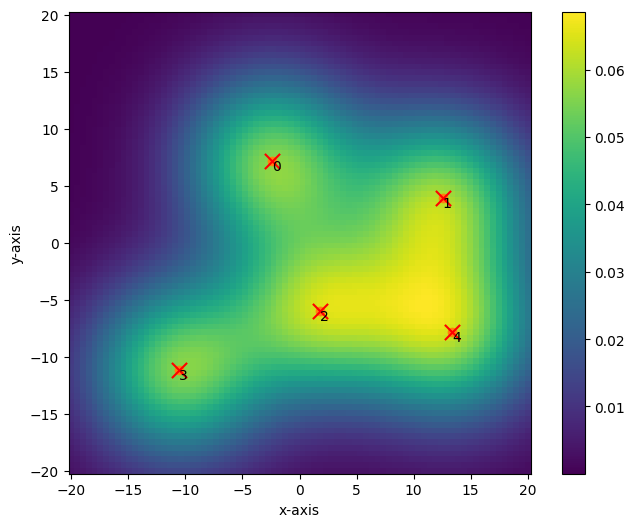

In [1]:
from aquapointer.density_canvas.DensityCanvas import DensityCanvas
from aquapointer.density_canvas.Lattice import Lattice
# define a canvas
origin = (-20, -20)
length = 40
npoints = 80
canvas = DensityCanvas(
    origin=origin,
    length_x=length,
    length_y=length,
    npoints_x=npoints,
    npoints_y=npoints,
)

# extract random centers with a minimal distance
# and a padding from border
seed = 18389
n_centers = 5 #number of Gaussians
min_dist = 10 #minimal distance between gaussians
padding = 6 #minimal distance of Gaussian centers from border
amplitude = 10 #amplitude of the Gaussians
variance = 30 #variance of the Gaussians

canvas.set_randomized_gaussian_density(
    n_centers = n_centers,
    amplitude = amplitude,
    variance = variance,
    minimal_distance = min_dist,
    padding = padding,
    seed = seed
)

canvas.set_lattice(lattice=Lattice(canvas.gaussian_centers), centering=False)

# To see the result, call the draw method with draw_centers=True
canvas.draw(draw_centers=True, draw_lattice=True, figsize=(8,6))

In [2]:
from aquapointer.digital.vqe import VQE
from aquapointer.digital.ansatz import QAOA_ansatz

# General imports
import numpy as np

# Pre-defined ansatz circuit, operator class
from qiskit.primitives import BackendSampler
from qiskit_aer import AerSimulator

backend = AerSimulator()
sampler = BackendSampler(backend=backend, options={"shots": int(1e4)})

def get_qubo_coeffs(canvas):
    estimated_variance = 30
    estimated_amplitude = 10

    # canvas.set_poisson_disk_lattice(spacing=(5, 5))
    canvas.set_lattice(lattice=Lattice(canvas.gaussian_centers), centering=False)
    _ = canvas.calculate_pubo_coefficients(
            p = 2, #order of the PUBO, p=2 effectively creates a QUBO
            params = [estimated_amplitude, estimated_variance],
            efficient_qubo=True
        )
    # canvas.force_lattice_size(7)
    # canvas.draw(draw_lattice=True)
    # rescaled_positions = canvas._lattice._coords
    qubo_coeffs = canvas._pubo

    return qubo_coeffs

In [3]:
# from the qubo coefficients dictionary, create a qubo matrix:
def get_random_qubo(seed, n_centers=5):

    # define a canvas
    origin = (-20, -20)
    length = 40
    npoints = 80
    canvas = DensityCanvas(
        origin=origin,
        length_x=length,
        length_y=length,
        npoints_x=npoints,
        npoints_y=npoints,
    )
    # extract random centers with a minimal distance
    # and a padding from border
    # n_centers = 5 #number of Gaussians
    min_dist = 3 #minimal distance between gaussians
    padding = 6 #minimal distance of Gaussian centers from border
    amplitude = 5 #amplitude of the Gaussians
    variance = 15 #variance of the Gaussians

    canvas.set_randomized_gaussian_density(
        n_centers = n_centers,
        amplitude = amplitude,
        variance = variance,
        minimal_distance = min_dist,
        padding = padding,
        seed = seed
    )
    # To see the result, call the draw method with draw_centers=True
    # canvas.draw(draw_centers=True, draw_lattice=True, figsize=(8,6))

    qubo = get_qubo_coeffs(canvas)
    
    qubo_matrix = np.zeros((len(qubo['coeffs'][1]), len(qubo['coeffs'][1])))

    for key in qubo['coeffs'][1].keys():
        qubo_matrix[key[0]][key[0]] = qubo['coeffs'][1][key]

    for key in qubo['coeffs'][2].keys():
        qubo_matrix[key] = qubo['coeffs'][2][key]
        qubo_matrix[key[::-1]] = qubo['coeffs'][2][key]
        

    return qubo_matrix

In [5]:
qubo_matrix = get_random_qubo(seed = 5)

# classical brute-force solution
from aquapointer.digital.qubo_utils import find_optimum
solution = find_optimum(qubo=qubo_matrix)
solution

('00101', -0.6571563837743178)

In [7]:
qubo_matrices = []
sizes = list(range(5,15))
for n in sizes:
    qubo_matrices.append(get_random_qubo(seed=42, n_centers=n))


In [9]:
import numpy as np
import matplotlib.pyplot as plt

def ising_energy(assignment: np.ndarray, qubo: np.ndarray) -> float:
    r""" Given a binary string x and a QUBO matrix Q, computes the inner product <x, Qx>.

    Args:   
        assignment: numpy array, 0,1-valued.
        qubo: 2d numpy array.

    Returns:
        Float given by computing the inner product <x, Qx>.
    
    
    """ 
    return np.transpose(assignment) @ qubo @ assignment

def bitfield(n: int, L: int) -> list[int]:
    result = np.binary_repr(n, L)
    return [int(digit) for digit in result]

def find_optimum(qubo: np.ndarray) -> list:
    r""" Brute-force approach to solving the QUBO problem: finding the optimal
    bitstring x that minimizes <x, Qx> where Q is the QUBO matrix.

    Args:
        qubo: 2d numpy array.
    
    Returns:
        Tuple of a bitstring and minimal energy (such that <x, Qx> is minimized).   
    
    """ 
    shape = qubo.shape
    L = shape[0]

    energies = []

    for n in range(2**L):
        b = bitfield(n=n, L=L)
        energy = ising_energy(assignment=b, qubo=qubo)
        energies.append(energy)

    energies.sort()
          
    return energies

# Function to calculate the eigenvalue gap
def get_gap(M, k=1):
    energies = find_optimum(M)
    # print(energies)
    gap = energies[k] - energies[0]
    return gap

# Sizes of the QUBO matrices
sizes = list(range(5, 15))

# Number of random matrices per size
num_matrices_per_size = 400

mean_gaps = []
std_gaps = []
for n in sizes:
    gaps = []
    for i in range(num_matrices_per_size):
        M = get_random_qubo(seed=i, n_centers=n)
        gaps.append(get_gap(M))
    # print(gaps)
    mean_gaps.append(np.mean(gaps))
    std_gaps.append(np.std(gaps))

errorbar_gaps = np.array(std_gaps)*(1.64/np.sqrt(num_matrices_per_size))


array([0.00191849, 0.00189169, 0.00181177, 0.00175464, 0.00173016,
       0.00164193, 0.00144755, 0.00160074, 0.00146024, 0.00146852])

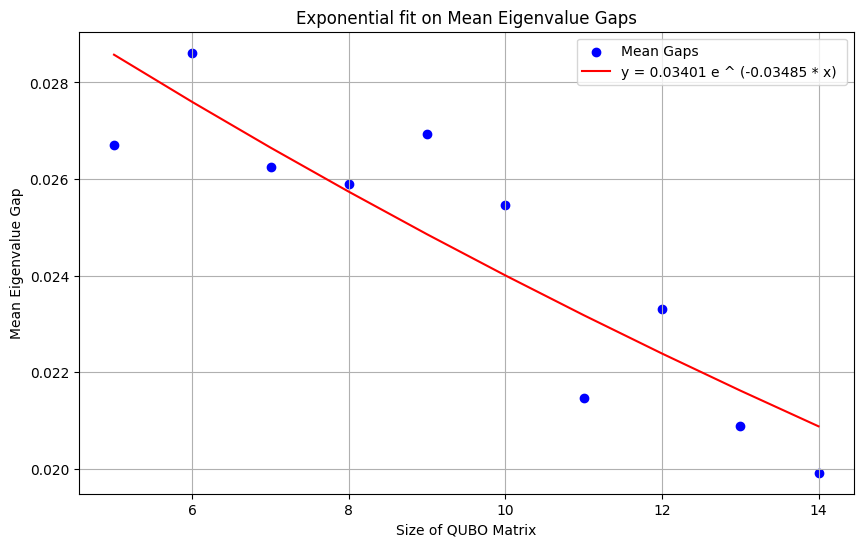

In [15]:
from scipy.optimize import curve_fit
def one_over_x_model(x, a, b):
    return a * np.exp(b * x)

sizes = list(range(5, 15))

# Fit the mean runtimes to the polynomial model
popt, pcov = curve_fit(one_over_x_model, sizes, mean_gaps)
a, b = popt

# Generate fitted data for the polynomial model
y_pred = one_over_x_model(np.array(sizes), a, b)

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(sizes, mean_gaps, color='blue', label='Mean Gaps')
plt.plot(sizes, y_pred, color='red', label='y = {:.5f} e ^ ({:.5f} * x) '.format(a, b))
plt.xlabel('Size of QUBO Matrix')
plt.ylabel('Mean Eigenvalue Gap')
plt.title('Exponential fit on Mean Eigenvalue Gaps')
plt.legend()
plt.grid(True)
plt.savefig('eigvgap_lreg.pdf')
plt.show()

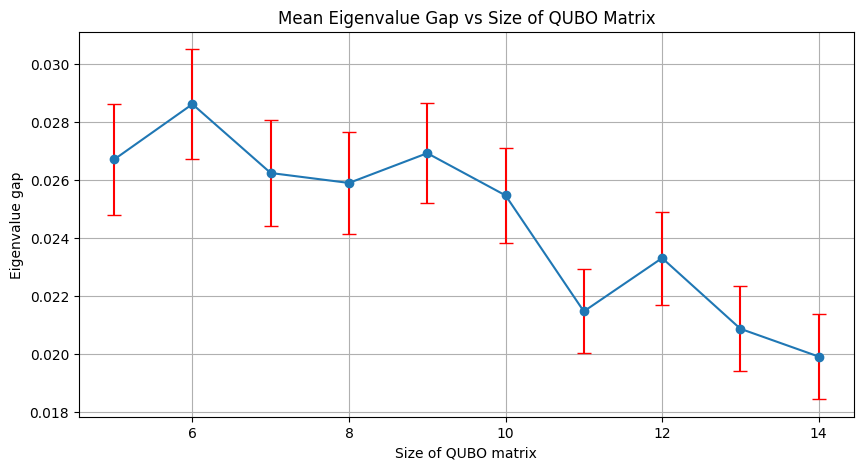

In [16]:
# Plot sizes against mean gaps with error bars
plt.figure(figsize=(10,5))
plt.errorbar(sizes, mean_gaps, yerr=errorbar_gaps, fmt='-o', capsize=5, capthick=1, ecolor='red')
plt.xlabel('Size of QUBO matrix')
plt.ylabel('Eigenvalue gap')
plt.title('Mean Eigenvalue Gap vs Size of QUBO Matrix')
plt.grid(True)
plt.savefig('eigvgap.pdf')
plt.show()

### Eigenvalue gap between the ground state and some $k$-th excited state

In [23]:
'''
A QUBO problem of size n has 2^n possible assignments.
Let's consider the lowest 10% of energies and compute the gap.
'''
# Function to calculate the eigenvalue gap
def get_gap(M, k=1):
    energies = find_optimum(M)
    # print(energies)
    gap = energies[k] - energies[0]
    return gap

# Sizes of the QUBO matrices
sizes = list(range(5, 15))

# Number of random matrices per size
num_matrices_per_size = 400

mean_gaps = []
std_gaps = []
for n in sizes:
    k = 5
    gaps = []
    for i in range(num_matrices_per_size):
        M = get_random_qubo(seed=i, n_centers=n)
        gaps.append(get_gap(M, k))
    # print(gaps)
    mean_gaps.append(np.mean(gaps))
    std_gaps.append(np.std(gaps))

errorbar_gaps = np.array(std_gaps)*(1.64/np.sqrt(num_matrices_per_size))

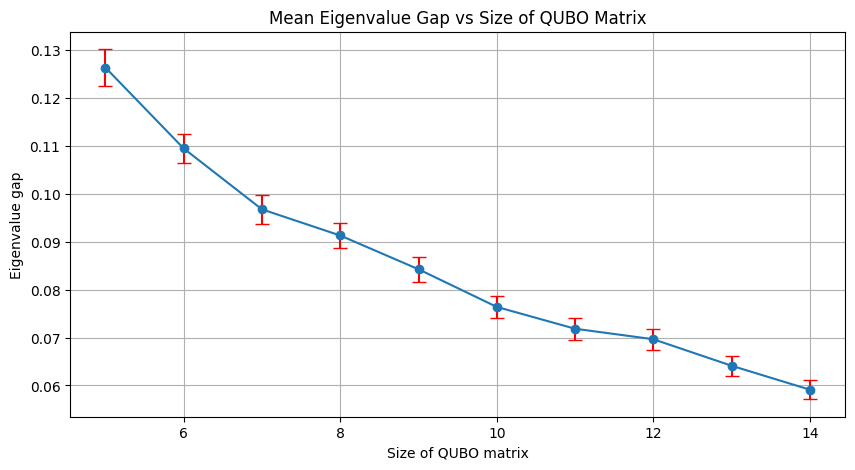

In [24]:
# Plot sizes against mean gaps with error bars
plt.figure(figsize=(10,5))
plt.errorbar(sizes, mean_gaps, yerr=errorbar_gaps, fmt='-o', capsize=5, capthick=1, ecolor='red')
plt.xlabel('Size of QUBO matrix')
plt.ylabel('Eigenvalue gap')
plt.title('Mean Eigenvalue Gap vs Size of QUBO Matrix')
plt.grid(True)
plt.savefig('eigvgap.pdf')
plt.show()